<a href="https://colab.research.google.com/github/slp22/deep-learning-project/blob/main/dl_diabetic_retinopathy_mvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Deep Learning | MVP

# Diabetic Retinopathy<a id='top'></a> 

## **Analysis Goal**  
The client, the [National Eye Institute](https://www.nei.nih.gov/), part of the National Institutes of Health, wants a model that can quickly identify [diabetic retinopathy](https://www.nei.nih.gov/learn-about-eye-health/eye-conditions-and-diseases/diabetic-retinopathy) in patients participating in early phase clinical trials.

**RQ:** How well can a neural network diagnose diabetic retinopathy from a retinal image?

## **Process**
**Data source:** [Diabetic Retinopathy](https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-2015-data-colored-resized)retinal images at various stages of the disease, modified from the [Diabetic Retinopathy Detection Kaggle Competition](https://www.kaggle.com/c/diabetic-retinopathy-detection); images are courtesy of [EyePACS](http://eyepacs.com/),a free platform for retinopathy screening. The dataset (n=35,126) is classified as:  
  0 - No_DR (healthy eye)
  1 - Mild
  2 - Moderate
  3 - Severe
  4 - Proliferate_DR

**Error Metric:** Accuracy (for MVP), precision and recall (for final model)

**Base Model:** 
  * First iteration deep learning model:
    * accuracy: 0.1530
    * val_accuracy: 0.1550

## **Preliminary Conclusions**
The model with 5 epochs does not perform well. 

The next step for this analysis is to run the model with more epochs; and use transfer learning to improve the performance. 

## Imports

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
import pandas as pd
import pickle
import PIL
import random
import seaborn as sns
import shutil
import sklearn as sk
import tensorflow as tf
from tqdm import tqdm
import warnings

from glob import glob
from tensorflow import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing import image as IMG
from keras.preprocessing.image import ImageDataGenerator
# from keras.utils import to_categorical

from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

%pylab inline
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']  # or svg
pd.set_option('display.max_colwidth', None)
sns.set(context='notebook', style='whitegrid')
warnings.filterwarnings('ignore')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Matplotlib version:", matplotlib.__version__)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras Version:", tf.keras.__version__)
print("Scikit-learn version:", sk.__version__)


Populating the interactive namespace from numpy and matplotlib
Num GPUs Available:  1
Matplotlib version: 3.2.2
Numpy version: 1.21.6
Pandas version: 1.3.5
TensorFlow version: 2.8.2
Keras Version: 2.8.0
Scikit-learn version: 1.0.2


## 1 | Dataset: [Diabetic Retinopathy Retinal Images](https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-2015-data-colored-resized)

Code adapted from [github/PurpleGrace](https://github.com/PurpleGrace/Deep_Learning_Tools_Image_Classification/blob/main/code/1.EDA_Sample_Images.ipynb)


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sandralparedes","key":"746c1c655d0796973a3d3552fbcc97a5"}'}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! pwd
! ls

/content
drive  kaggle.json  sample_data


In [5]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [6]:
! kaggle datasets download -d sovitrath/diabetic-retinopathy-2015-data-colored-resized

100% 1.93G/1.94G [00:17<00:00, 145MB/s]
100% 1.94G/1.94G [00:17<00:00, 116MB/s]


In [7]:
# unzip kaggle file

zip_ref = zipfile.ZipFile('diabetic-retinopathy-2015-data-colored-resized.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [8]:
# show number of classes and images

source_images_path = '/tmp/colored_images/colored_images/'
extracted_directories_path = os.listdir(source_images_path)

for image_directory in extracted_directories_path:
  print(image_directory, len(os.listdir(os.path.join(source_images_path, image_directory))))

Proliferate_DR 708
Mild 2443
No_DR 25810
Severe 873
Moderate 5292


## 2 | Exploratory Data Analysis

In [9]:
# read in files and diagnosis label and store as dataframe

filepath = '/tmp/colored_images/colored_images'
dataframe = {'image_path':[],'diagnosis':[]}

for diagnosis in os.listdir(filepath):
    print(diagnosis)
    if diagnosis != 'colored_images':        
        for image in os.listdir(filepath +"/"+diagnosis):
            if image != 'Dataset':
                dataframe['image_path'].append(filepath +"/"+diagnosis+"/"+ image)
                dataframe['diagnosis'].append(diagnosis)
dataframe = pd.DataFrame(dataframe)  
dataframe.info()
dataframe.head(2)

Proliferate_DR
Mild
No_DR
Severe
Moderate
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35126 entries, 0 to 35125
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  35126 non-null  object
 1   diagnosis   35126 non-null  object
dtypes: object(2)
memory usage: 549.0+ KB


,image_path,diagnosis
0,/tmp/colored_images/colored_images/Proliferate_DR/10321_left.png,Proliferate_DR
1,/tmp/colored_images/colored_images/Proliferate_DR/43997_left.png,Proliferate_DR


Data set n = 35,126

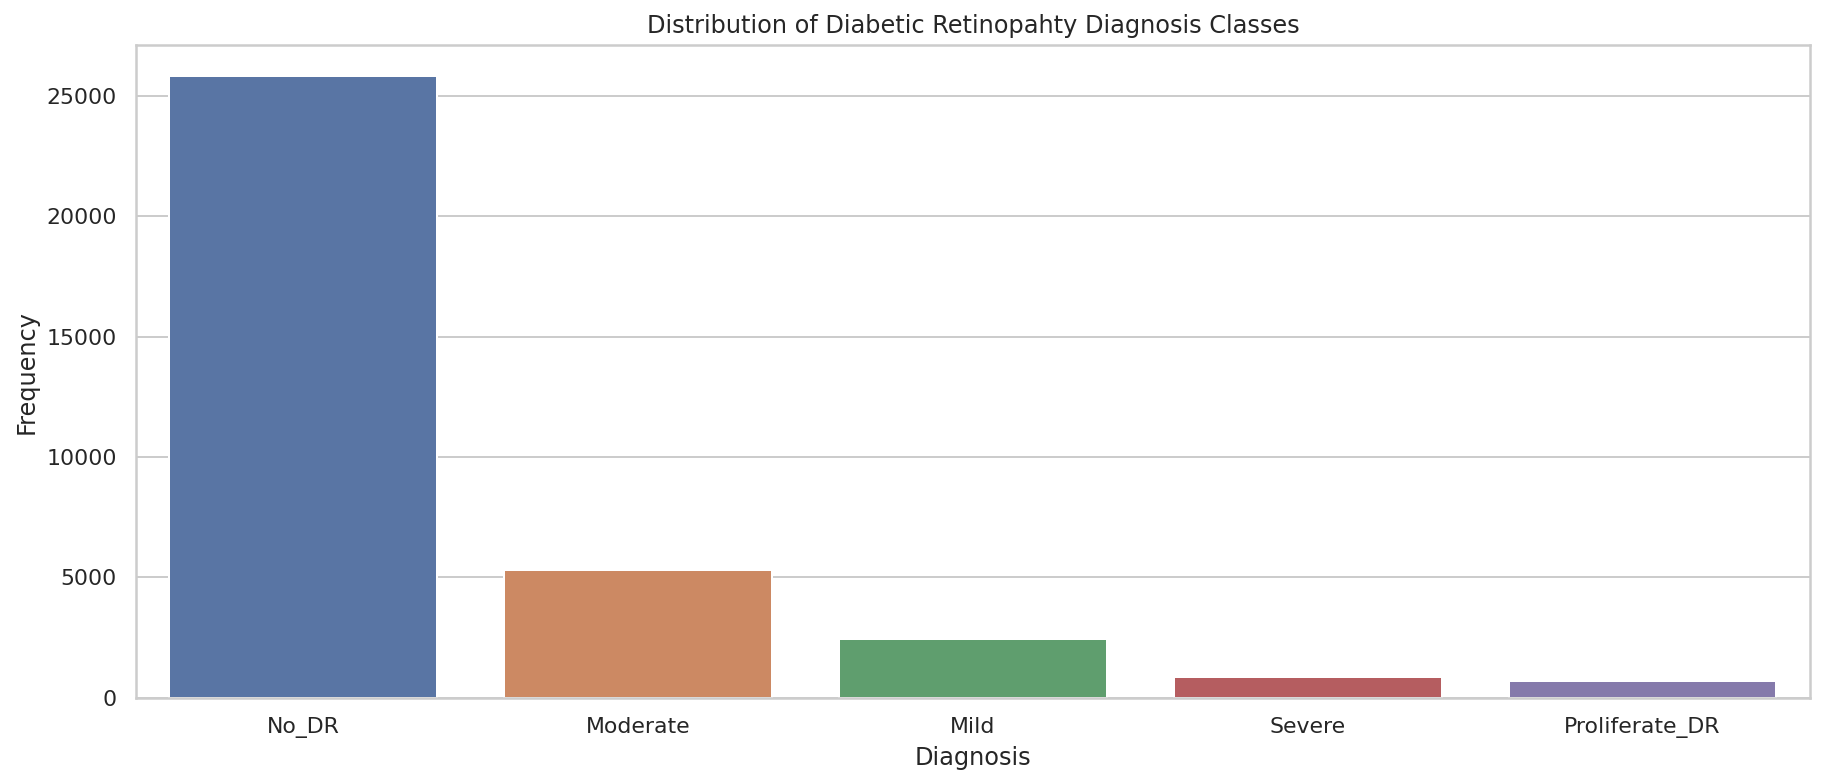

In [10]:
# distribution of five diagnosis classes in order of severity of disease

plt.figure(figsize=(15,6))
sns.barplot(dataframe.diagnosis.value_counts().index,
            dataframe.diagnosis.value_counts(),
            palette=None)
plt.title("Distribution of Diabetic Retinopahty Diagnosis Classes")
plt.xlabel("Diagnosis")
plt.ylabel("Frequency");


Classes are unbalanced

No Diabetic Retinopthy
Datatype: <class 'PIL.PngImagePlugin.PngImageFile'>


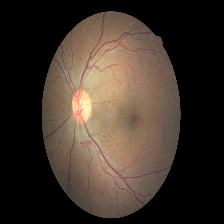

In [11]:
# view one healthy eye image

path = '/tmp/colored_images/colored_images/No_DR/10003_left.png'

healthy_image = tf.keras.preprocessing.image.load_img(
   path,
   grayscale=False, 
   color_mode="rgb", 
  #  target_size=(256, 256),
   interpolation="nearest")

print('No Diabetic Retinopthy')
print('Datatype:', type(healthy_image))
healthy_image 


Proliferate Diabetic Retinopthy
Datatype: <class 'PIL.PngImagePlugin.PngImageFile'>


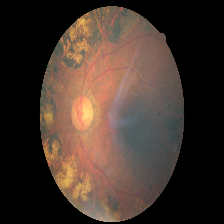

In [12]:
# view one proliferate DR image (most advanced stage of disease)

path = '/tmp/colored_images/colored_images/Proliferate_DR/10017_left.png'

proliferate_image = tf.keras.preprocessing.image.load_img(
   path,
   grayscale=False, 
   color_mode="rgb", 
  #  target_size=(256, 256), 
   interpolation="nearest")

print('Proliferate Diabetic Retinopthy')
print('Datatype:', type(proliferate_image))
proliferate_image 


### Validation Split

In [14]:
# set up for train/test split

temp_path = '/tmp'
raw_data_dir_name = 'raw_data'
train_data_dir_name = 'train'
test_data_dir_name = 'test'
raw_data_directories = [train_data_dir_name, test_data_dir_name]

images_path =  os.path.join(temp_path, raw_data_dir_name)
tmp_directories = os.listdir(temp_path)

def build_raw_data_directory(parent, directory):
  dir_path = os.path.join(parent, directory)
  os.mkdir(dir_path)
  for dir in extracted_directories_path:
    os.mkdir(os.path.join(dir_path, dir))

if raw_data_dir_name not in tmp_directories:
  os.mkdir(images_path)
  for directory in raw_data_directories:
    build_raw_data_directory(images_path, directory)
else:
  print(raw_data_dir_name, " already exist")
  images_path_directories = os.listdir(images_path)
  for directory in raw_data_directories:
    if directory not in images_path_directories:
      build_raw_data_directory(images_path, directory)




In [15]:
# split data into train/test folders

distribution = 0.2

raw_data_path = os.path.join(temp_path, raw_data_dir_name)
test_data_path_root = os.path.join(raw_data_path, test_data_dir_name)
train_data_path_root = os.path.join(raw_data_path, train_data_dir_name)

data_dirs = os.listdir(source_images_path)
for dir in data_dirs:
  path = os.path.join(source_images_path, dir)
  test_data_path = os.path.join(test_data_path_root, dir)
  train_data_path = os.path.join(train_data_path_root, dir)
  images = os.listdir(path)
  print(path, test_data_path)
  for image in images:
    random_number = random.uniform(0, 1)
    is_test_image = random_number < distribution
    source_image_path = os.path.join(path, image)
    # shutil.copy(src, dst)
    if is_test_image:
      shutil.copy(source_image_path, test_data_path)
      # print(source_image_path, "goes to test", test_data_path)
    else:
      shutil.copy(source_image_path, train_data_path)
      # print(source_image_path, "goes to train", train_data_path)

test_data_path_root = os.path.join(raw_data_path, test_data_dir_name)
train_data_path_root = os.path.join(raw_data_path, train_data_dir_name)

test_dirs = os.listdir(test_data_path_root)
train_dirs = os.listdir(train_data_path_root)

for dir in test_dirs:
  path = os.path.join(test_data_path_root, dir)
  files = os.listdir(path)
  print(path, len(files))

for dir in train_dirs:
  path = os.path.join(train_data_path_root, dir)
  files = os.listdir(path)
  print(path, len(files))

/tmp/colored_images/colored_images/Proliferate_DR /tmp/raw_data/test/Proliferate_DR
/tmp/colored_images/colored_images/Mild /tmp/raw_data/test/Mild
/tmp/colored_images/colored_images/No_DR /tmp/raw_data/test/No_DR
/tmp/colored_images/colored_images/Severe /tmp/raw_data/test/Severe
/tmp/colored_images/colored_images/Moderate /tmp/raw_data/test/Moderate
/tmp/raw_data/test/Proliferate_DR 141
/tmp/raw_data/test/Mild 471
/tmp/raw_data/test/No_DR 5194
/tmp/raw_data/test/Severe 181
/tmp/raw_data/test/Moderate 1027
/tmp/raw_data/train/Proliferate_DR 567
/tmp/raw_data/train/Mild 1972
/tmp/raw_data/train/No_DR 20616
/tmp/raw_data/train/Severe 692
/tmp/raw_data/train/Moderate 4265


# Logistic Regression

In [16]:
class_names = ['Proliferate_DR', 'Mild','No_DR', 'Severe', 'Moderate']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
size = (224,224)
num_classes = len(class_names)

In [19]:


def load_data(class_names):
    
    datasets = ['/tmp/raw_data/train', 
                '/tmp/raw_data/test']
    output = []
    
    # Iterate through training and test set folders
    for dataset in datasets:

        images = []
        labels = []
        folders = os.listdir(dataset)
        folders = [value for value in folders if value != ".DS_Store"]
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in folders:
            label = class_names_label[folder]
            
            # Iterate through each image in the folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the image
                image = cv2.imread(img_path)
#                 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#                 image = cv2.resize(image, size) 

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = None)
        labels = np.array(labels, dtype = None)   
        
        output.append((images, labels))

    return output

In [20]:
(train_images, train_labels), (test_images, test_labels) = load_data(class_names)


Loading /tmp/raw_data/train


100%|██████████| 4265/4265 [00:04<00:00, 873.85it/s]


Loading /tmp/raw_data/test


100%|██████████| 1027/1027 [00:01<00:00, 882.36it/s]


In [31]:
test_images = test_images.flatten()
print('test images type:', type(test_images))
print('test images shape:', test_images.shape)

test images type: <class 'numpy.ndarray'>
test images shape: (1055803392,)


In [32]:
train_images = train_images.flatten()
print('train images type:', type(train_images))
print('train images shape:', train_images.shape)

train images type: <class 'numpy.ndarray'>
train images shape: (4231643136,)


## 3 | Deep Learning Model

### Deep Learning First Model

Code source: https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d 

In [ ]:
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [ ]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/tmp/raw_data/train',  
        target_size=(150, 150), 
        batch_size=batch_size,
        class_mode='binary')  

validation_generator = test_datagen.flow_from_directory(
        '/tmp/raw_data/test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 28095 images belonging to 5 classes.
Found 7031 images belonging to 5 classes.


In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size
        )

model.save_weights('first_try.h5')  

Epoch 1/5
125/125 [==============================] - 15s 118ms/step - loss: -214507824.0000 - accuracy: 0.1370 - val_loss: -578096064.0000 - val_accuracy: 0.1825
Epoch 2/5
125/125 [==============================] - 14s 114ms/step - loss: -2003340928.0000 - accuracy: 0.1605 - val_loss: -4200994304.0000 - val_accuracy: 0.1275
Epoch 3/5
125/125 [==============================] - 15s 117ms/step - loss: -8443093504.0000 - accuracy: 0.1550 - val_loss: -14637317120.0000 - val_accuracy: 0.1587
Epoch 4/5
125/125 [==============================] - 14s 112ms/step - loss: -26486697984.0000 - accuracy: 0.1581 - val_loss: -39455670272.0000 - val_accuracy: 0.1625
Epoch 5/5
125/125 [==============================] - 14s 111ms/step - loss: -64640176128.0000 - accuracy: 0.1530 - val_loss: -94855258112.0000 - val_accuracy: 0.1550
